# Importing Dataset and Packages

In [1]:
from utils import *

In [2]:
# Importing datasets
train_trend = pd.read_csv('train_trend.csv')
test_trend = pd.read_csv('test_trend.csv')
weather = pd.read_csv('weather.csv') 

In [3]:
#Changing date to date_time object
train_trend.date = pd.to_datetime(train_trend.date)
test_trend.date = pd.to_datetime(test_trend.date)
weather.date = pd.to_datetime(weather.date)

In [4]:
#Combining dataset for proper feature engineering
combined_dataset = pd.concat([train_trend, test_trend])

# Adding exogenous variables/ features

Exogenous variables are relevant features that help to understand the observed time series better and produce the most accurate and robust forecasts possible (Arunraj, Ahrens & Fernandes, 2016; Brownlee, 2016; Singh, 2019). 

Based on the data, I chose to implement the following features/ exogenous variables, going by the sources highlighted above.
1. Weather - Average daily temperature in Fahrenheit and average amount of daily rainfall (in inches) recorded at the stores that were used in the data. I believe these are the most relevant variables out of the other variables in the dataset. The other variables were things like codesum, depart, sealevel etc.
2. Binary variable representing whether the day is a US holiday or not. This can be modified as need be for other countries' holidays. 
3. Date-time features e.g. day of week, day of the month, month in the year, whether the day is a weekend or not (binary variable)
4. Lagged values - showing the units at t-1, t-2, t-3 etc. I chose to make lagged values up to 30 days before because of the significant correlations shown in the autocorrelation plot below. Also, I did not want too many data entries to be removed because the test set is only 2 years, but removing one month of the data out of 24 months would not be very significant.
5. Rolling mean, min and max - using the pre-determined lag above, these features would be getting the average, minimum and maximum values from the window of data from the previous 30 days.

## Weather

In [5]:
#Selecting the relevant variables
weather = weather[['date','tavg','preciptotal']]

#Observing Dataset Structure
observe_data_structure(weather)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 3 columns):
date           20517 non-null datetime64[ns]
tavg           20517 non-null object
preciptotal    20517 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 481.0+ KB
None

 Summary Statistics 

                       date   tavg preciptotal
count                 20517  20517       20517
unique                 1035    112         285
top     2013-02-09 00:00:00      M        0.00
freq                     20   1469       11909
first   2012-01-01 00:00:00    NaN         NaN
last    2014-10-31 00:00:00    NaN         NaN


In [6]:
warnings.filterwarnings("ignore")

#M is missing data; T is for trace, meaning there was less than 0.01 inch of rain

#Adjusting for trace
for i in range(len(weather.tavg)):
     if weather.preciptotal[i] =='  T':
        weather.preciptotal[i] = 0.005      

#Making the average temperature and preciptotal variables numeric and making missing data 0
weather.tavg = pd.to_numeric(weather.tavg, errors='coerce')
weather.preciptotal = pd.to_numeric(weather.preciptotal, errors='coerce')

#Taking the average of average temperature and preciptotal variables across the dataset
consolidated_weather = weather.groupby('date').mean().reset_index()

#Dropping Christmas day data inline with demand data
consolidated_weather = consolidated_weather.drop([359,723]).reset_index()
consolidated_weather= consolidated_weather.drop(columns = ['index'])

#Adding weather to dataset

combined_dataset['tavg'] = consolidated_weather.tavg
combined_dataset['preciptotal'] = consolidated_weather.preciptotal

In [7]:
#Creating list of US Holidays
usholidays = [date2 for date2,name in \
              sorted(holidays.US(years=[2012,2013,2014]).items())]
usholidays = [e for e in usholidays if e not in \
              {datetime.date(2012, 1, 2), datetime.date(2012, 11, 12)}]

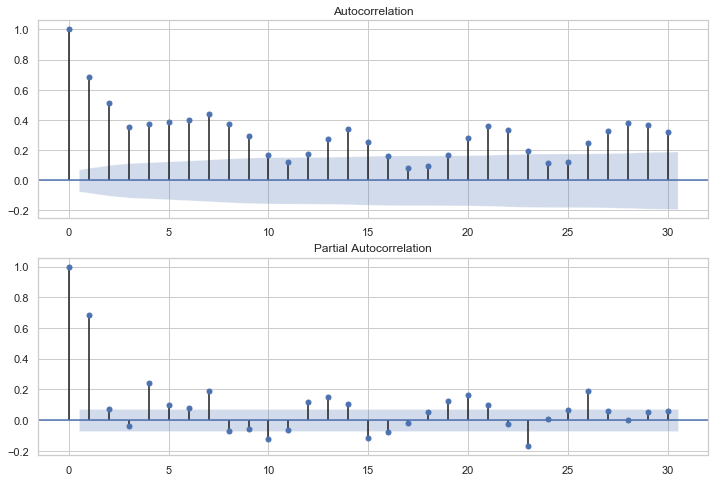

In [8]:
#ACF and PACF plots to determine appropriate lag for feature engineering
acf_pacf_plotter(train_trend.units)

## Feature Engineering for other variables

In [13]:
warnings.filterwarnings("ignore")
    
def feature_engineering(file):
    
    """This function does feature engineering on the dataset.
    """ 
    
    warnings.filterwarnings("ignore")
    
    #Rolling mean, minimum and maximum - 30 days window, given the lag determined by autocorrelation plot
    #The .shift() function prevents data leakage
    
    file['rolling_mean'] = file.units.rolling(window=30).mean().shift()
    file['rolling_min'] = file.units.rolling(window=30).min().shift()
    file['rolling_max'] = file.units.rolling(window=30).max().shift()
    
    #Lagged values - 30 days, given the lag determined by autocorrelation plot
    for i in range(1, 31):
        file["lag_{}".format(i)] = file.units.shift(i)
        
    #Date-time features
    file['day_of_week'] = file.date.dt.weekday + 1
    file['month'] = file.date.dt.month 
    file['day_of_month'] = file.date.dt.day
    file['is_weekend'] = 0 
    file['holiday'] = 0
    
    #Dropping NA values after creating the rolling mean and lagged values
    file = file.dropna()
    
    for i in range(len(file)):
        
        #Making rolling mean an integer
        file.rolling_mean.iloc[i] = round(file.rolling_mean.iloc[i])
        
        #Binary variable representing if the day is a holiday or not
        if file.date.iloc[i] in usholidays:
            file.holiday.iloc[i] = 1
            
        #Binary variable representing if the day is a weekend or not
        if file.day_of_week.iloc[i] == 6 or file.day_of_week.iloc[i] == 7:
            file.is_weekend.iloc[i] = 1
          
    return file

combined_dataset = feature_engineering(combined_dataset)

In [10]:
#One-hot encoding day of week, month and day of month variables
combined_dataset = pd.get_dummies(combined_dataset, \
                                  columns=['day_of_week','month','day_of_month'])

In [11]:
#Splitting into train and test sets

train_trend = combined_dataset.loc\
[combined_dataset.date <= datetime.datetime(2013, 12, 31)]

test_trend = combined_dataset.loc\
[combined_dataset.date > datetime.datetime(2013, 12, 31)]

In [12]:
# Saving datasets to .csv files for the forecasting notebook
train_trend = train_trend.to_csv(r'train_trend.csv', index = None, header=True)
test_trend = test_trend.to_csv(r'test_trend.csv', index = None, header=True)